# Thematic Screener: Spotlight Companies Championing Your Themes

## Why It Matters

Thematic investing requires systematic identification of companies aligned with structural trends, but manually tracking exposure across thousands of documents is inefficient and inconsistent. As mega-trends like AI and decarbonization reshape markets, investors need scalable ways to quantify which companies are genuinely positioned to benefit.

## What It Does

The `ThematicScreener` class in the bigdata-research-tools package helps solve this problem. Designed for analysts, PMs, and strategists managing thematic portfolios or scouting new ideas, it systematically connects companies to investment themes using unstructured data from news, earnings calls, and filings.

## How It Works

ThematicScreener combines **LLM-powered theme taxonomies**, **semantic content retrieval**, and **structured scoring methodologies** to deliver:

- **Automated theme breakdown** into specific, measurable sub-categories
- **Systematic positioning analysis** to identify how companies align with key themes
- **Cross-sector exposure comparison** enabling portfolio-level thematic assessment
- **Qualitative-to-quantitative transformation** that turns narrative signals into structured, actionable insights

## A Real-World Use Case

This cookbook walks through a full workflow, from defining a theme to quantifying company exposure, using "Supply Chain Reshaping" analysis across Top US 100 companies as a practical example.


## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [1]:
import datetime
start = datetime.datetime.now()

try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed or not available")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [2]:
import os
import sys


current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Import the core libraries needed for regulatory issues analysis, including the custom report generation classes and data processing tools.

In [20]:
import os
from logging import Logger, getLogger
from typing import Dict, List, Optional

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from pandas import DataFrame, merge
import plotly
import plotly.io as pio
import seaborn as sns
from IPython.display import HTML, display

from src.tool import html_content
from src.tool import display_figures_cookbooks

from bigdata_client import Bigdata
from bigdata_client.models.entities import Company
from bigdata_client.models.search import DocumentType

from bigdata_research_tools.labeler.screener_labeler import ScreenerLabeler
from bigdata_research_tools.search.screener_search import search_by_companies
from bigdata_research_tools.themes import (
    generate_theme_tree,
    stringify_label_summaries,
)

from bigdata_research_tools.workflows.utils import get_scored_df
from bigdata_research_tools.excel import ExcelManager

## Optional: Plotly Display Configuration

For better visualization rendering, you can also set the Plotly renderer:

In [4]:
import plotly.io as pio

# Try to detect the environment and set appropriate renderer
try:
    # Check if we're in JupyterLab
    import os
    if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ or 'JPY_SESSION_NAME' in os.environ:
        pio.renderers.default = 'jupyterlab'
        print("✅ Plotly configured for JupyterLab")
    else:
        # Default for VS Code, Jupyter Notebook, etc.
        pio.renderers.default = 'plotly_mimetype+notebook'
        print("✅ Plotly configured for Jupyter/VS Code")
except:
    # Fallback to a more universal renderer
    pio.renderers.default = 'notebook'
    print("✅ Plotly configured with fallback renderer")

✅ Plotly configured for Jupyter/VS Code


## Define Output Paths

We define the output paths for our thematic screening results.

In [5]:
# Define output file paths for our results
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/thematic_screener_results.xlsx"

## Load Credentials

In [6]:
from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [7]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining your Screening Parameters

-  **Main Theme** (``main_theme``): The central concept to explore
-  **Company Universe** (``companies``): The set of companies to screen
-  **Time Period** (``start_date`` and ``end_date``): The date range over which to
   run the search
-  **Document Type** (``document_type``): Specify which documents to search over
   (transcripts, filings, news)
-  **Sources** (``sources``): Specify set of sources within a document type, for
   example which news outlets (available via Bigdata API) you wish to
   search over
-  **Fiscal Year** (``fiscal_year``): If the document type is transcripts or
   filings, fiscal year needs to be specified
-  **Model Selection** (``llm_model``): The LLM model used to mindmap the theme
   and label the search result chunks
-  **Rerank Threshold** (``rerank_threshold``): By setting this value, you’re
   enabling the cross-encoder which reranks the results and selects
   those whose relevance is above the percentile you specify (0.7 being
   the 70th percentile). More information on the re-ranker can be found
   [here](https://sdk.bigdata.com/en/latest/how_to_guides/rerank_search.html).
-  **Focus** (``focus``): Specify a focus within the main theme. This will then
   be used in building the LLM generated mindmapper

In [8]:
# ===== Theme Definition =====
main_theme = "Supply Chain Reshaping"

# ===== Company Universe (from Watchlist) =====
# Get Top US 100 watchlist from Bigdata.com
top100_watchlist_id = "44118802-9104-4265-b97a-2e6d88d74893"
watchlist = bigdata.watchlists.get(top100_watchlist_id)
companies = bigdata.knowledge_graph.get_entities(watchlist.items)

# ===== LLM Specification =====
llm_model = "openai::gpt-4o-mini"

# ===== Transcript Configuration =====
document_type = DocumentType.TRANSCRIPTS
fiscal_year = 2024

# ===== Enable/Disable Reranker =====
rerank_threshold = None

# ===== Specify Time Range =====
start_date = "2024-03-01"
end_date = "2025-03-01"

## Mindmap a Theme Taxonomy with Bigdata Research Tools

You can leverage Bigdata Research Tools to generate a comprehensive theme taxonomy with an LLM, breaking down a megatrend into smaller,
well-defined concepts for more targeted analysis.

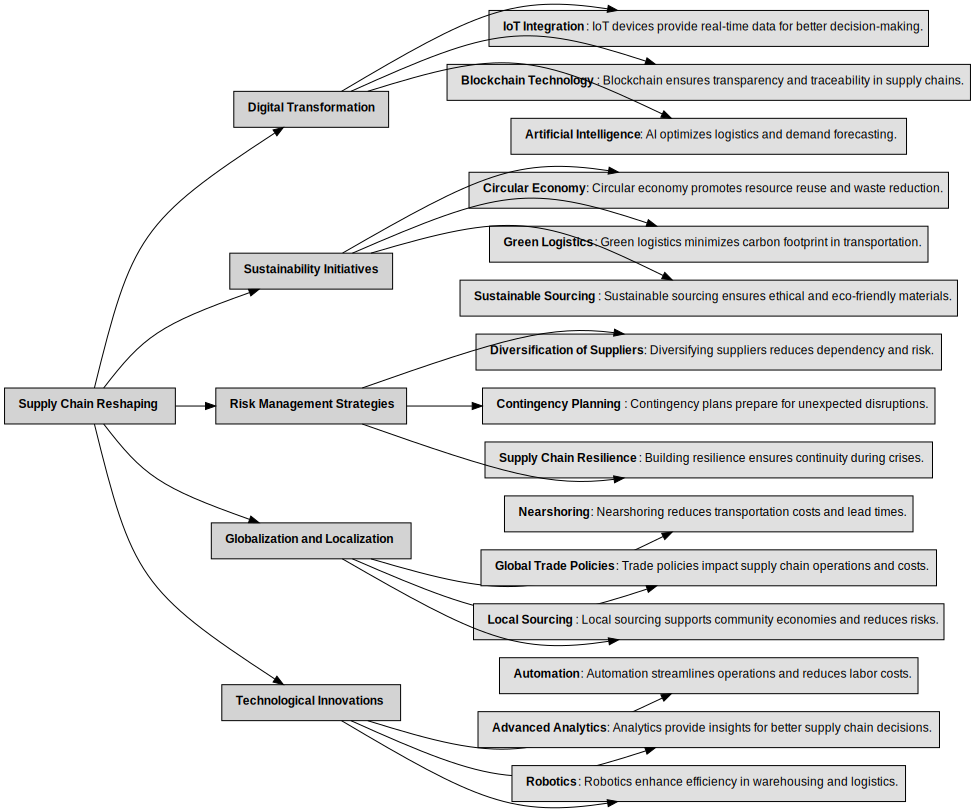

In [9]:
theme_tree = generate_theme_tree(
    main_theme=main_theme
)

theme_tree.visualize()

The taxonomy tree includes descriptive sentences that explicitly connect each sub-theme back to the "Supply Chain Reshaping" main theme, ensuring all search results remain contextually relevant to our central trend.

In [10]:
node_summaries = theme_tree.get_summaries()
node_summaries

['Supply Chain Reshaping involves transforming supply chains for efficiency and resilience.',
 'Digital tools enhance visibility and efficiency in supply chain operations.',
 'IoT devices provide real-time data for better decision-making.',
 'Blockchain ensures transparency and traceability in supply chains.',
 'AI optimizes logistics and demand forecasting.',
 'Sustainability practices reduce environmental impact in supply chains.',
 'Circular economy promotes resource reuse and waste reduction.',
 'Green logistics minimizes carbon footprint in transportation.',
 'Sustainable sourcing ensures ethical and eco-friendly materials.',
 'Risk management identifies and mitigates supply chain vulnerabilities.',
 'Diversifying suppliers reduces dependency and risk.',
 'Contingency plans prepare for unexpected disruptions.',
 'Building resilience ensures continuity during crises.',
 'Balancing global and local strategies enhances supply chain effectiveness.',
 'Nearshoring reduces transportatio

## Retrieve Content using Bigdata’s Search Capabilities

With the theme taxonomy and screening parameters, you can leverage the
Bigdata API to run a search on company transcripts. We need to define 3
more parameters for searching:

-  **Frequency** (``freq``): The frequency of the date ranges to search over.
   Supported values:

   -  `Y`: Yearly intervals.
   -  `M`: Monthly intervals.
   -  `W`: Weekly intervals.
   -  `D`: Daily intervals. Defaults to `3M`.

-  **Document Limit** (``document_limit``): The maximum number of documents to
   return per query to Bigdata API.
-  **Batch Size** (``batch_size``): The number of entities to include in a
   single batched query.

In [11]:
freq = "3M"
document_limit = 10
batch_size = 10

df_sentences = search_by_companies(
    companies=companies,
    sentences=node_summaries,
    start_date=start_date,
    end_date=end_date,
    scope=document_type,
    fiscal_year=fiscal_year,
    rerank_threshold=rerank_threshold,
    freq=freq,
    document_limit=document_limit,
    batch_size=batch_size,
)

Processing transcripts results...: 100%|██████████| 4999/4999 [00:00<00:00, 54539.63it/s]


In [12]:
df_sentences.head(5)

,timestamp_utc,document_id,sentence_id,headline,entity_id,document_type,is_reporting_entity,entity_name,entity_sector,entity_industry,entity_country,entity_ticker,text,other_entities,entities,masked_text,other_entities_map
0,2024-03-05 14:00:00+00:00,ED54958784318C49870C14B39785E581,ED54958784318C49870C14B39785E581-13,Target Corporation: Q4 2024 Earnings Call on M...,F6DCE4,transcripts,True,Target Corp.,Consumer Services,Broadline Retailers,United States,TGT,"For now, I'll just emphasize the focus we're p...","United Parcel Service Inc., FedEx Corp., Shipt...","[{'key': 'FAE021', 'name': 'United Parcel Serv...","For now, I'll just emphasize the focus Target ...","[(1, Shipt Inc.), (2, FedEx Corp.), (3, United..."
1,2024-03-05 14:00:00+00:00,ED54958784318C49870C14B39785E581,ED54958784318C49870C14B39785E581-170,Target Corporation: Q4 2024 Earnings Call on M...,F6DCE4,transcripts,True,Target Corp.,Consumer Services,Broadline Retailers,United States,TGT,"In addition, we also see benefit from digital ...",,"[{'key': 'F6DCE4', 'name': 'Target Corp.', 'ti...","In addition, we also see benefit from digital ...",None
2,2024-03-05 14:00:00+00:00,ED54958784318C49870C14B39785E581,ED54958784318C49870C14B39785E581-39,Target Corporation: Q4 2024 Earnings Call on M...,F6DCE4,transcripts,True,Target Corp.,Consumer Services,Broadline Retailers,United States,TGT,We take care of our team so they can take care...,,"[{'key': 'F6DCE4', 'name': 'Target Corp.', 'ti...",Target Company take care of Target Company tea...,None
3,2024-03-05 14:00:00+00:00,ED54958784318C49870C14B39785E581,ED54958784318C49870C14B39785E581-110,Target Corporation: Q4 2024 Earnings Call on M...,F6DCE4,transcripts,True,Target Corp.,Consumer Services,Broadline Retailers,United States,TGT,"Before I include my recap of 2023, I want to p...",,"[{'key': 'F6DCE4', 'name': 'Target Corp.', 'ti...","Before I include my recap of 2023, I want to p...",None
4,2024-03-05 14:00:00+00:00,ED54958784318C49870C14B39785E581,ED54958784318C49870C14B39785E581-10,Target Corporation: Q4 2024 Earnings Call on M...,F6DCE4,transcripts,True,Target Corp.,Consumer Services,Broadline Retailers,United States,TGT,"Over the next decade, we expect to open more t...",,"[{'key': 'F6DCE4', 'name': 'Target Corp.', 'ti...","Over the next decade, Target Company expect to...",None


## Label the Results

Use an LLM to analyze each text chunk and determine its relevance to the sub-themes. Any chunks which aren't explicitly linked to supply chain reshaping will be filtered out.

In [13]:
labeler = ScreenerLabeler(llm_model=llm_model)
df_labels = labeler.get_labels(
    main_theme=main_theme,
    labels=list(theme_tree.get_terminal_label_summaries().keys()),
    texts=df_sentences["masked_text"].tolist(),
)

Querying OpenAI...: 100%|██████████| 9293/9293 [07:55<00:00, 19.55it/s]


In [14]:
# Merge and process results
df = merge(df_sentences, df_labels, left_index=True, right_index=True)
df = labeler.post_process_dataframe(df)

## Assess Thematic Exposure Across Your Investment Universe

We’ll look at the top 10 most exposed companies to supply chain
reshaping. The function `get_scored_df` will calculate the composite
thematic score, summing up the scores across the sub-themes for each
company (`df_company`) or industry (`df_industry`).

In [15]:
df_company, df_industry = DataFrame(), DataFrame()

df_company = get_scored_df(
    df, index_columns=["Company", "Ticker", "Industry"], pivot_column="Theme"
)
df_industry = get_scored_df(
    df, index_columns=["Industry"], pivot_column="Theme"
)

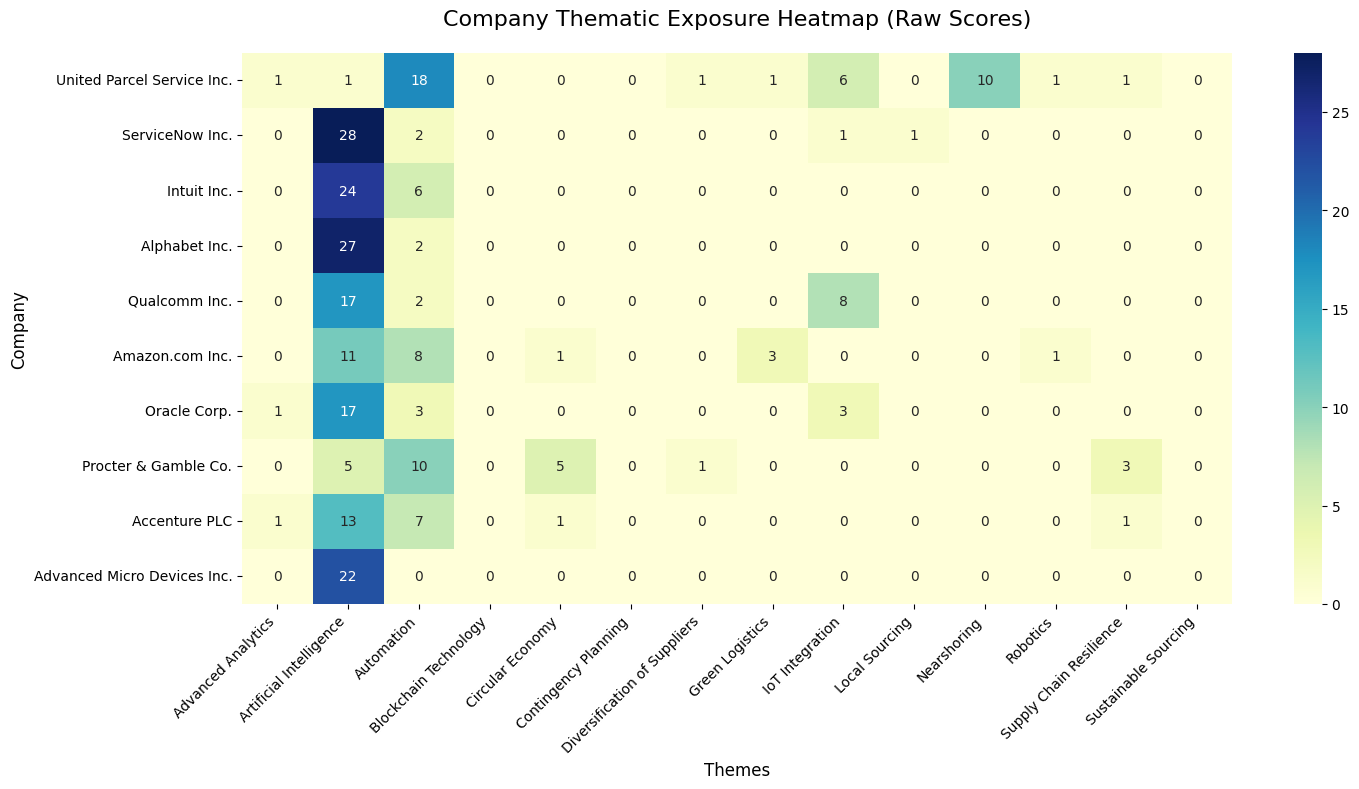

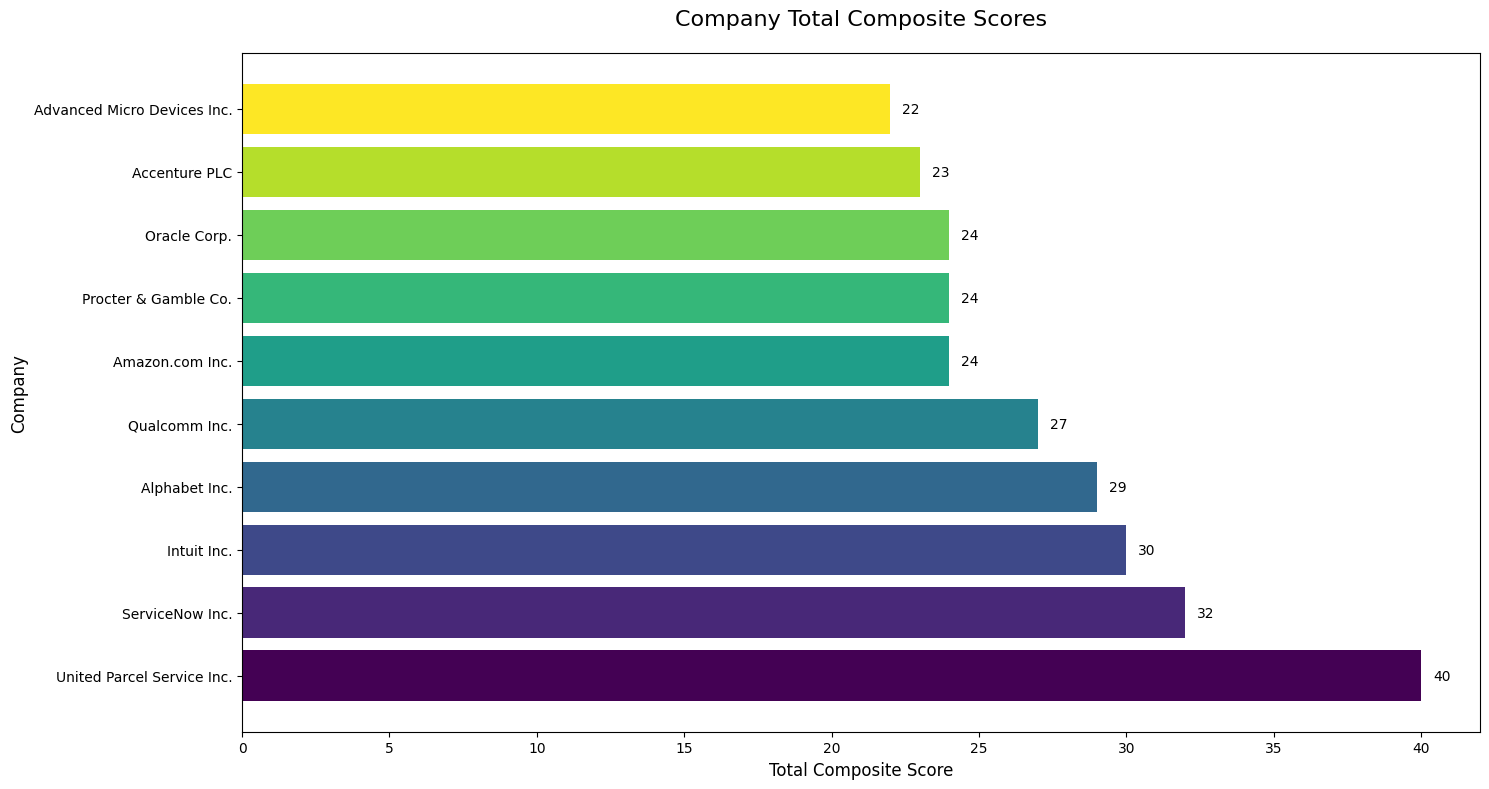

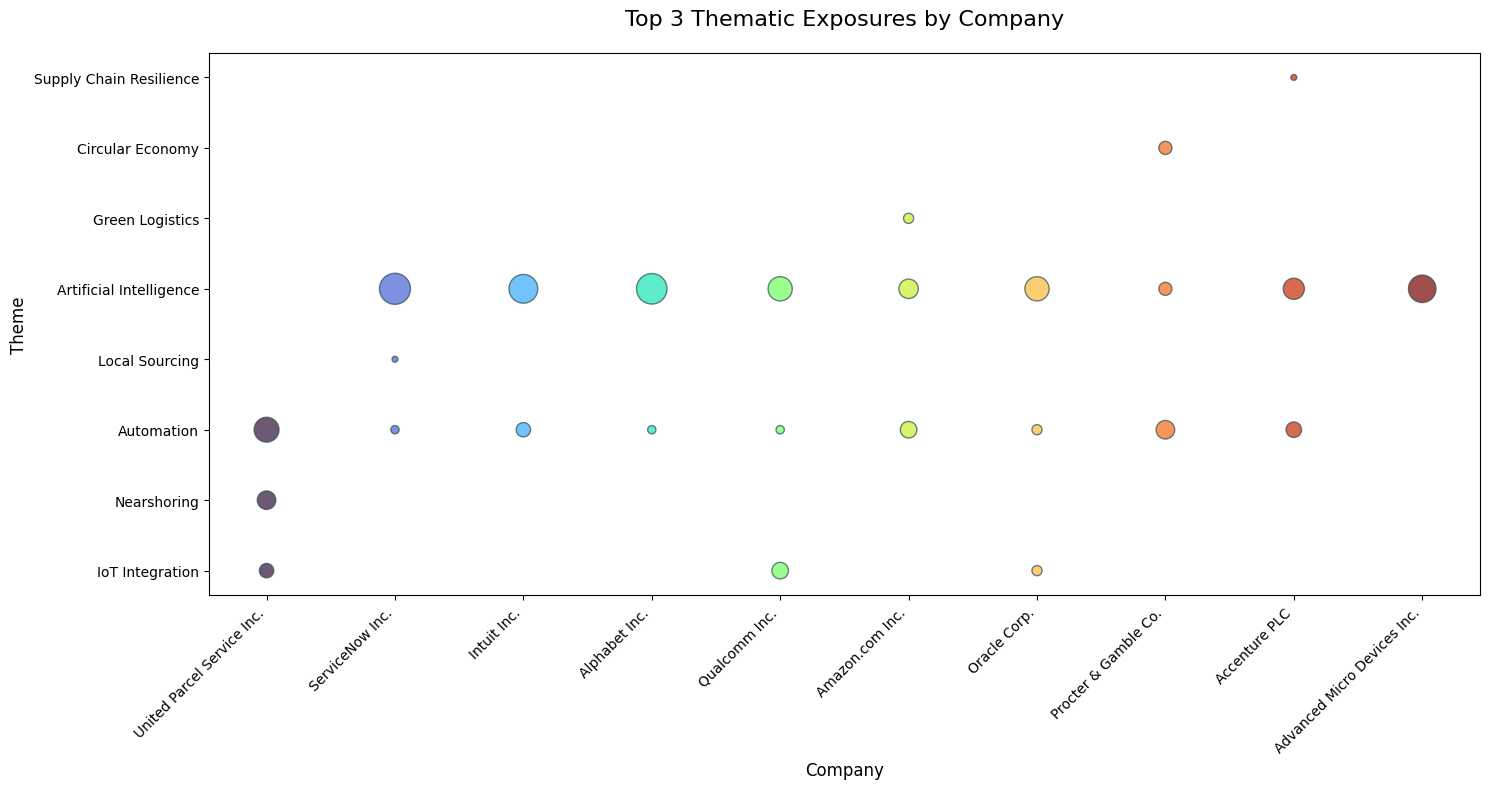

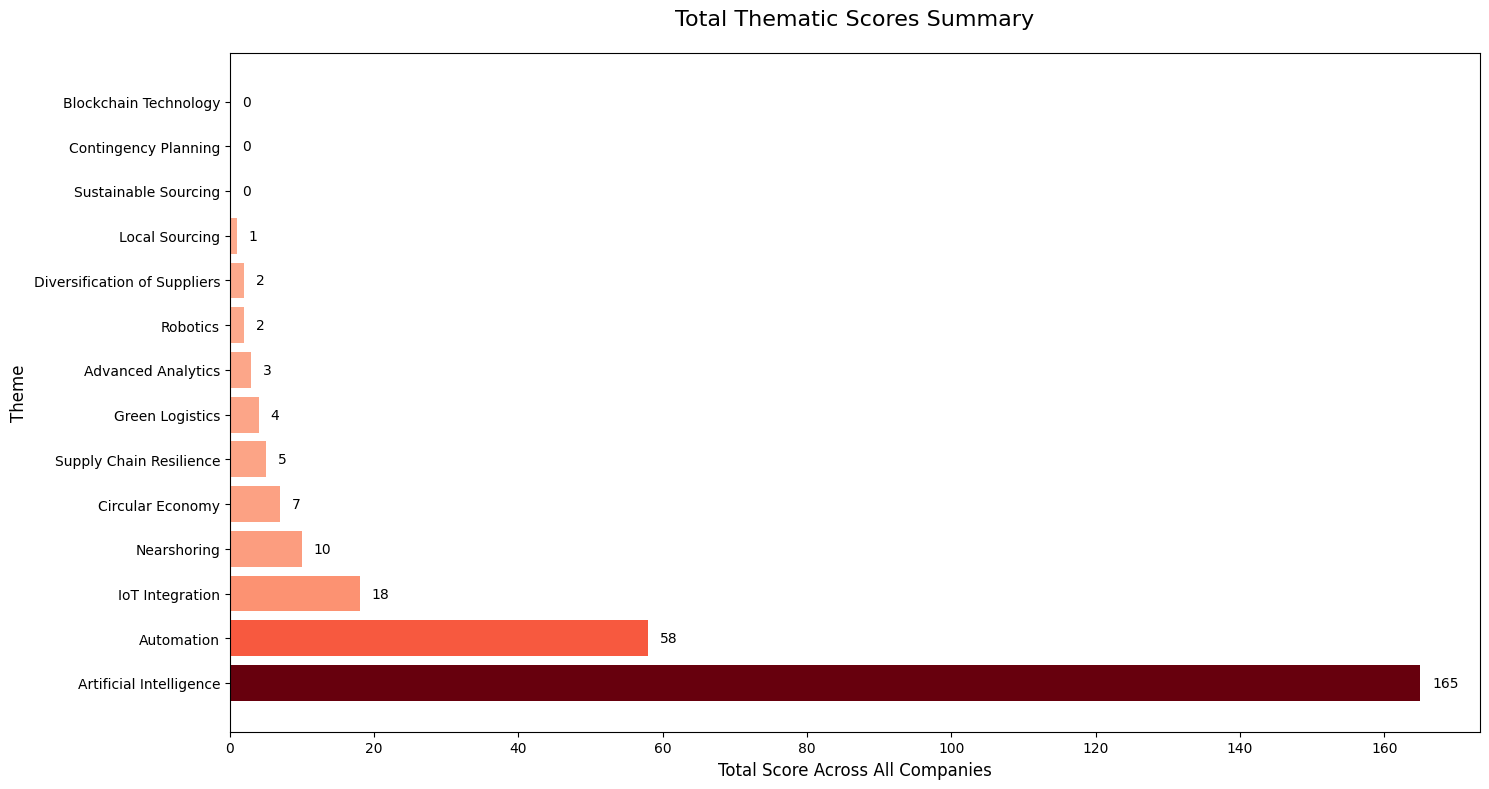

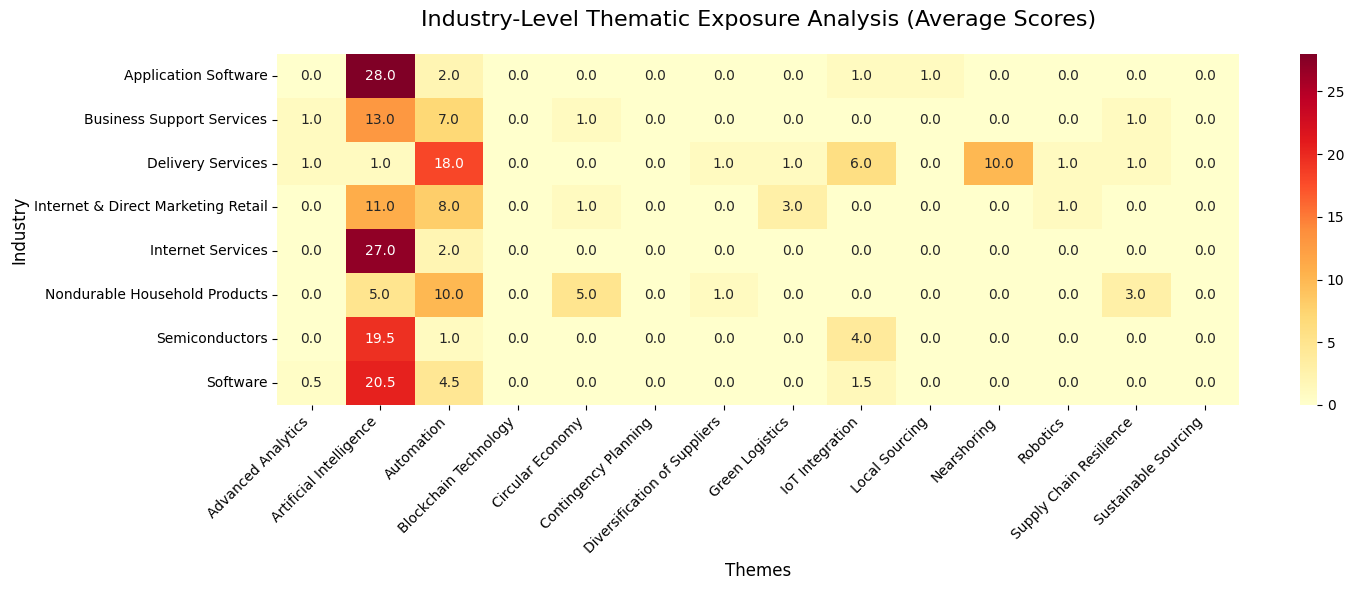

In [36]:
display_figures_cookbooks(df_company, interactive=False) #set interactive=True (or False) to enable (or disable) the interactive plot

In [17]:
display(HTML(html_content))

## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [18]:
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (df, "Semantic Labels", (0, 0)),
        (df_company, "By Company", (2, 4)),
        (df_industry, "By Industry", (2, 2))
    ]

    # Save the workbook
    excel_manager.save_workbook(df_args, export_path)

except Exception as e:
    print(f"Warning while exporting to excel: {e}")

In [19]:
print("Runtime:", datetime.datetime.now() - start)

Runtime: 0:13:18.529211
